## 🔥 LSTM Model for Remaining Useful Life (RUL) Prediction (PyTorch)

In this section, we upgrade the RNN model to a **Long Short-Term Memory (LSTM)** network.  
LSTMs are more powerful than vanilla RNNs because they use gating mechanisms to:

- Retain long-term dependencies  
- Prevent vanishing/exploding gradients  
- Model complex degradation patterns in engine health data  

This makes LSTMs one of the most popular architectures for Remaining Useful Life (RUL) prediction.

We will use the **same preprocessed inputs and sequence windows** created earlier:

- `X_train`, `y_train`  
- `X_valid`, `y_valid`  
- `X_test`, `y_test`  

Our workflow will include:

1. Creating a PyTorch Dataset for sequence data  
2. Defining an LSTM-based regression model  
3. Training the model  
4. Evaluating performance on the test set  
5. Inversely transforming predictions to real RUL units  


***
### 1️⃣ PyTorch Imports

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

import warnings
np.random.seed(34)
warnings.filterwarnings('ignore')

Using device: cpu


### 2️⃣ Build datasets

In [2]:
url = "https://raw.githubusercontent.com/Dr-AlaaKhamis/ISE518/refs/heads/main/datasets/nasa_rul.csv"
df = pd.read_csv(url)
print("Shape:", df.shape)
df.head()

Shape: (20631, 27)


,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


#### Data Preperation

In [3]:
df = df.sort_values(["unit_number","time_cycles"]).reset_index(drop=True)
units = df['unit_number'].unique()
train_units, test_units = train_test_split(units, test_size=0.2, random_state=42)
train_units, valid_units = train_test_split(train_units, test_size=0.2, random_state=42)

train_df = df[df.unit_number.isin(train_units)]
valid_df = df[df.unit_number.isin(valid_units)]
test_df  = df[df.unit_number.isin(test_units)]

# Ensure splits are proper independent DataFrames
train_df = train_df.copy()
valid_df = valid_df.copy()
test_df  = test_df.copy()

index_cols = ['unit_number', 'time_cycles']
target_col = 'RUL'
feature_cols = [c for c in df.columns if c not in index_cols + [target_col]]

# ---------- SCALE FEATURES ----------
x_scaler = MinMaxScaler()

train_df.loc[:, feature_cols] = x_scaler.fit_transform(train_df[feature_cols])
valid_df.loc[:, feature_cols] = x_scaler.transform(valid_df[feature_cols])
test_df.loc[:, feature_cols]  = x_scaler.transform(test_df[feature_cols])

# ---------- SCALE TARGET ----------
y_scaler = MinMaxScaler()

train_df.loc[:, target_col] = y_scaler.fit_transform(train_df[[target_col]])
valid_df.loc[:, target_col] = y_scaler.transform(valid_df[[target_col]])
test_df.loc[:, target_col]  = y_scaler.transform(test_df[[target_col]])

In [4]:
def create_sequences(df, seq_len, feat_cols, target_col):
    X, y = [], []
    for unit in df.unit_number.unique():
        unit_data = df[df.unit_number==unit]
        feats = unit_data[feat_cols].values
        targs = unit_data[target_col].values
        for i in range(len(unit_data)-seq_len+1):
            X.append(feats[i:i+seq_len])
            y.append(targs[i+seq_len-1])
    return np.array(X), np.array(y)

SEQ_LEN=30
X_train,y_train=create_sequences(train_df,SEQ_LEN,feature_cols,target_col)
X_valid,y_valid=create_sequences(valid_df,SEQ_LEN,feature_cols,target_col)
X_test,y_test=create_sequences(test_df,SEQ_LEN,feature_cols,target_col)


In [5]:
class RULDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_ds = RULDataset(X_train, y_train)
valid_ds = RULDataset(X_valid, y_valid)
test_ds  = RULDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)    

### 3️⃣ LSTM Model Definition

In [6]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]     # last time step
        return self.fc(out)

### 4️⃣ Initialize model

In [7]:
input_size = X_train.shape[2]
model = LSTMRegressor(input_size=input_size, hidden_size=64, num_layers=1).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### 5️⃣Training Loop

In [8]:
epochs = 25
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            valid_loss += criterion(y_pred, y_batch).item()

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Valid Loss: {valid_loss/len(valid_loader):.4f}")


Epoch 1/25 | Train Loss: 0.0189 | Valid Loss: 0.0150
Epoch 2/25 | Train Loss: 0.0118 | Valid Loss: 0.0145
Epoch 3/25 | Train Loss: 0.0109 | Valid Loss: 0.0140
Epoch 4/25 | Train Loss: 0.0098 | Valid Loss: 0.0130
Epoch 5/25 | Train Loss: 0.0093 | Valid Loss: 0.0132
Epoch 6/25 | Train Loss: 0.0090 | Valid Loss: 0.0119
Epoch 7/25 | Train Loss: 0.0086 | Valid Loss: 0.0127
Epoch 8/25 | Train Loss: 0.0081 | Valid Loss: 0.0107
Epoch 9/25 | Train Loss: 0.0079 | Valid Loss: 0.0110
Epoch 10/25 | Train Loss: 0.0078 | Valid Loss: 0.0109
Epoch 11/25 | Train Loss: 0.0077 | Valid Loss: 0.0113
Epoch 12/25 | Train Loss: 0.0077 | Valid Loss: 0.0105
Epoch 13/25 | Train Loss: 0.0076 | Valid Loss: 0.0099
Epoch 14/25 | Train Loss: 0.0073 | Valid Loss: 0.0102
Epoch 15/25 | Train Loss: 0.0074 | Valid Loss: 0.0099
Epoch 16/25 | Train Loss: 0.0072 | Valid Loss: 0.0104
Epoch 17/25 | Train Loss: 0.0072 | Valid Loss: 0.0097
Epoch 18/25 | Train Loss: 0.0071 | Valid Loss: 0.0103
Epoch 19/25 | Train Loss: 0.0071 | Va

### 6️⃣ Evaluate LSTM on Test Set

In [9]:
model.eval()
preds, trues = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch)
        preds.append(y_pred.cpu().numpy())
        trues.append(y_batch.numpy())

y_pred_scaled = np.concatenate(preds).flatten()
y_true_scaled = np.concatenate(trues).flatten()

# inverse-transform RUL
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1,1))
y_true = y_scaler.inverse_transform(y_true_scaled.reshape(-1,1))

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"\n🔥 PyTorch LSTM Test RMSE: {rmse:.2f}")


🔥 PyTorch LSTM Test RMSE: 25.57


### 7️⃣ Plot Predictions

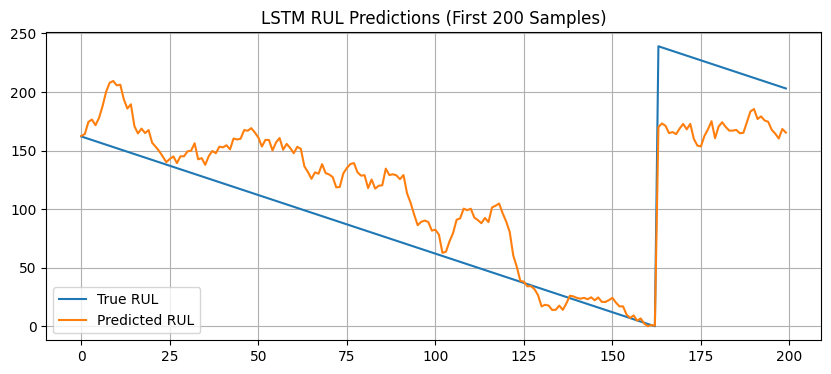

In [12]:
plt.figure(figsize=(10,4))
plt.plot(y_true[:200], label="True RUL")
plt.plot(y_pred[:200], label="Predicted RUL")
plt.legend(); plt.grid()
plt.title("LSTM RUL Predictions (First 200 Samples)")
plt.show()